# Set-up Environment

## Initalize variables

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Use this before loading tensorflow
import random
import numpy as np
import tensorflow as tf

def random_seed():
    return os.urandom(42)

def reset_seeds(random_state = 42):
    try:
        tf.keras.utils.set_random_seed(random_state)
        return 0
    except: 
        random.seed(random_state)
        np.random.seed(random_state)
        tf.random.set_seed(random_state) # Tensorflow 2.9
    try:
        from tensorflow import set_random_seed # Tensorflow 1.x
        set_random_seed(random_state)
        return 2
    except:
        pass
    return 1

max_gpus = len(tf.config.list_physical_devices('GPU'))
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
"""
Reset all random seeds
"""               
reset_seeds(123)

1

In [13]:
#### Basic set-up
tif_file_name ='brady_ai_stack.grd'
image_channels = 7 # Was 9
#tif_file_name ='/store03/thesis/git/doe-som/brady_som_output.grd'
#image_channels = 3

num_samples = 100000
kernel_pixels = 19
my_patience = 5
kernel_internal = 3

print('[Info] *** Configuration ***')
print('File     : ', tif_file_name)
print('Bands    : ', image_channels)
print('Samples  : ', num_samples)
print('Kernel   : ', kernel_pixels, ' pixels per side')
print('Channels : ', image_channels)
print('CNN size : (', kernel_internal, 'x', kernel_internal, ') maximum kernel size')
print('Patience : ', my_patience)
print('GPUs max : ', max_gpus)

[Info] *** Configuration ***
File     :  brady_ai_stack.grd
Bands    :  7
Samples  :  100000
Kernel   :  19  pixels per side
Channels :  7
CNN size : ( 3 x 3 ) maximum kernel size
Patience :  5
GPUs max :  1


## Load libraries and finish set-up

In [14]:
num_epochs = 150
batch_size = 200

BS=batch_size

NUM_CLASSES = 2         # Default number of classes ("Geothermal", "Non-Geothermal")
IMAGE_DIMS = (kernel_pixels, kernel_pixels, image_channels)
BATCH_DIMS = (None, kernel_pixels, kernel_pixels, image_channels)
KERNEL_PIXELS = kernel_pixels
CHANNELS = image_channels

num_classes = NUM_CLASSES
augment_data = True

# Load libraries
# import gc
# from matplotlib import pyplot

print('[Info] *** Configuration ***')
print('Classes    : ', num_classes)
print('Epochs     : ', num_epochs)
print('Batch size : ', batch_size)

[Info] *** Configuration ***
Classes    :  2
Epochs     :  150
Batch size :  200


## Create image manipulation classes

In [15]:
# Helper class, generates data for keras
from jigsaw.jigsaw import DataGenerator
from jigsaw.rasterspcv import Kernel3D, GeoTiffSlicer

## Create cross-validation class from rasters

In [16]:
from jigsaw.rasterspcv import RasterSpCV

### [Optional] Test class RasterSpCV

In [ ]:
rSpCV = RasterSpCV(tif_file_name, kernel_pixels, num_channels = 7, sample = 10, verbose=1)

In [ ]:
cv = rSpCV.SpatialCV()
rSpCV.slicer.land_matrix.shape

In [ ]:
for tr, ts in cv:
    print(".")
    pass
print(ts)

In [ ]:
k=(np.flatnonzero(rSpCV.folding.Fold==2))
random.shuffle(k)
k[:min(10,len(k))]

## Functions to create jigsaw

In [17]:
# from jigsaw import jigsaw_m, jigsaw_m_end


In [18]:
from jigsaw import build_jigsaw

# Builds model

### [Optional] Test Jigsaw model creation

In [ ]:
from tensorflow.keras.utils import plot_model
import gc

#m = tf.keras.models.clone_model(model3)
m = tf.keras.models.clone_model(build_jigsaw( internal_size=3, num_classes=2, 
                                             image_dim = (kernel_pixels, 19, kernel_pixels), verbose=1))

gc.collect()
# Plots architecture
m_plt = plot_model(m) # , show_shapes=True)
m.summary()
m_plt

In [ ]:
from IPython.display import display
m_plt = plot_model(m)
display(m_plt)

# [Optional] Test Cross Validation

In [ ]:
rSpCV = RasterSpCV(tif_file_name, kernel_pixels, num_channels = image_channels, sample = 100000, verbose=0, augment = True)


In [ ]:
from tensorflow.keras.utils import to_categorical
cv = rSpCV.SpatialCV()
X = rSpCV.X()
y = rSpCV.y()
y_binary = to_categorical(y)

from matplotlib import pyplot
f, axarr = pyplot.subplots(1,2)
axarr[0].imshow(X[1][:,:,1])
axarr[1].imshow(X[1][:,:,1])
pyplot.show()

In [ ]:
f, axarr = pyplot.subplots(1,2)
axarr[0].imshow(X[1][:,:,1])
axarr[1].imshow(X[1][:,:,1])
pyplot.show()

In [ ]:
reset_seeds()
cv = rSpCV.SpatialCV()
X = rSpCV.X()
y = rSpCV.y()
y_binary = to_categorical(y)

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
def BAcc(y_true, y_pred):
    #y_pred = np.ravel(y_true[:,1])
    y_true = np.ravel(y_true[:,1])
    #y_pred = np.argmax(y_pred, axis=-1)
    assert(len(y_true)==len(y_pred))
    b_acc = balanced_accuracy_score(y_true, y_pred)
    acc   = accuracy_score(y_true, y_pred)
    f1    = f1_score(y_true, y_pred)
    print("Acc  :", acc)
    print("Bacc :", b_acc)
    print("F-1  :", f1)
    return b_acc
    print("Acc:", np.count_nonzero(y_true==y_pred)/len(y_true))
    #print('y_true:', y_true)
    #print('y_pred:', y_pred)
    l = []
    for i in np.unique(y_true):
        a = np.ravel(np.asarray(y_true==(i)).nonzero())
        #print("Index:", a)
        a_score = np.count_nonzero(y_true[a]==y_pred[a])/len(a)
        l.append(a_score)
    b_acc = np.mean(l)
    #print("L   :",l)
    print("Bacc: ", b_acc)
    return b_acc

balanced_accuracy = make_scorer(BAcc)

m = KerasClassifier(build_jigsaw, internal_size = kernel_internal,
                    num_classes = num_classes,
                    image_dim = IMAGE_DIMS,
                    batch_size = 10, epochs = 10)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(m, X, y_binary, cv=cv, scoring = balanced_accuracy)

In [ ]:
a = np.array([1, 2, 3, 4, 5, 6])
a=np.reshape(a, (3,2))
print(a)
b=a[:,1].reshape(-1)
a=a[:,0].reshape(-1)

In [ ]:
np.ravel(np.asarray(a==1).nonzero())

In [ ]:
y_true = np.asarray([1,1,1,0,1,0],)
#y_true = np.asarray([0,1,0,0,1,1])
y_pred = [[0.9, 0.1],[0.1, 0.9],[0.7, 0.3],[0.8, 0.2],[0.15,0.85],[0.3,0.7]]
y_pred = np.argmax(y_pred)
y_pred = np.asarray([0,1,0,0,1,1])
print(y_true.shape)
print(y_pred.shape)

print("Same length:", len(y_true)==len(y_pred))
l = []
for i in np.unique(y_true):
    a = np.ravel(np.asarray(y_true==i).nonzero())
    a_score = np.count_nonzero(y_true[a]==y_pred[a])/len(a)
    l.append(a_score)
print(l)
    
np.mean(l)

scores = cross_val_score(m, X, y_binary, cv=cv)

In [ ]:
scores, np.mean(scores)

In [ ]:
# With 3x3 kernels
# Epochs A scores
#     10 F (array([0.69809216, 0.61910695, 0.94752526, 0.79340768, 0.84017217]), 0.7796608448028565)
#     10 T (array([0.96171987, 0.67508829, 0.72336709, 0.62722361, 0.97688884]), 0.792857539653778)
#     50 T (array([0.97121   , 0.98631495, 0.75165534, 0.60664952, 0.63382876]), 0.7899317145347595)

result_1 = []

# GridSearch Parameter Crossvalidation

In [19]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score, f1_score
import itertools

def BAcc(y_true, y_pred):
    y_true = np.ravel(y_true[:,1])
    assert(len(y_true)==len(y_pred))
    b_acc = balanced_accuracy_score(y_true, y_pred)
    acc   = accuracy_score(y_true, y_pred)
    f1    = f1_score(y_true, y_pred)
    print("Acc  :", acc)
    print("Bacc :", b_acc)
    print("F-1  :", f1)
    return b_acc
    print("Acc:", np.count_nonzero(y_true==y_pred)/len(y_true))
    l = []
    for i in np.unique(y_true):
        a = np.ravel(np.asarray(y_true==(i)).nonzero())
        a_score = np.count_nonzero(y_true[a]==y_pred[a])/len(a)
        l.append(a_score)
    b_acc = np.mean(l)
    #print("L   :",l)
    print("Bacc: ", b_acc)
    return b_acc

def Acc(y_true, y_pred):
    y_true = np.ravel(y_true[:,1])
    assert(len(y_true)==len(y_pred))
    acc   = accuracy_score(y_true, y_pred)
    return acc

def F_beta_1(y_true, y_pred):
    y_true = np.ravel(y_true[:,1])
    assert(len(y_true)==len(y_pred))
    f1   = f1_score(y_true, y_pred)
    return f1

balanced_accuracy = make_scorer(BAcc)
accuracy = make_scorer(Acc)
f1 = make_scorer(F_beta_1)



scoring = {"AUC": "roc_auc", "Accuracy": accuracy, 
           "Balanced accuracy": balanced_accuracy, "F-1": f1}

In [20]:
rSpCV = RasterSpCV(tif_file_name, kernel_pixels, num_channels = image_channels, 
                   sample = num_samples, verbose = 1,  augment = True)

Splitting input layer data with MiniBatchKMeans
Counts: [24527 46840 54560 22047 52026]
Labels: # 200000
Partitions: [0 1 2 3 4]
Shape of new tiff: (7, 1447, 912)


In [21]:
from keras.wrappers.scikit_learn import KerasClassifier

cv = rSpCV.RepeatedSpCV(n_repeats=1)
X = rSpCV.X()
y = rSpCV.y()
#tr, ts = next(cv)
#X2=X[tr]
#y=y[tr]
X2=X[np.arange(len(X))]
y_binary = to_categorical(y)

m = KerasClassifier(build_jigsaw,
                    #internal_size = kernel_internal,
                    num_classes = num_classes,
                    image_dim = IMAGE_DIMS,
                    batch_size = 10, epochs = 10)

parameters = {'internal_size':[3, 5, 7, 9, 11, 13]}

clf = GridSearchCV(m, parameters, 
                   cv=cv,
                   refit = "Balanced accuracy",
                   return_train_score=True,
                   scoring = scoring
                  )

clf.fit(X2, y_binary)


*** Building Jigsaw with up to 3x3 kernels
Epoch 1/10
17548/17548 [==============================] - 109s 6ms/step - loss: 1.4876 - accuracy: 0.7008
Epoch 2/10
17548/17548 [==============================] - 106s 6ms/step - loss: 1.3610 - accuracy: 0.7424
Epoch 3/10
17548/17548 [==============================] - 108s 6ms/step - loss: 1.2882 - accuracy: 0.7475
Epoch 4/10
17548/17548 [==============================] - 107s 6ms/step - loss: 1.2259 - accuracy: 0.7545
Epoch 5/10
17548/17548 [==============================] - 107s 6ms/step - loss: 1.1691 - accuracy: 0.7631
Epoch 6/10
17548/17548 [==============================] - 106s 6ms/step - loss: 1.1159 - accuracy: 0.7739
Epoch 7/10
17548/17548 [==============================] - 107s 6ms/step - loss: 1.0671 - accuracy: 0.7865
Epoch 8/10
17548/17548 [==============================] - 107s 6ms/step - loss: 1.0214 - accuracy: 0.7988
Epoch 9/10
17548/17548 [==============================] - 107s 6ms/step - loss: 0.9808 - accuracy: 0.8122
Epo

15316/15316 [==============================] - 104s 7ms/step - loss: 1.0531 - accuracy: 0.8132
Epoch 8/10
15316/15316 [==============================] - 105s 7ms/step - loss: 1.0061 - accuracy: 0.8243
Epoch 9/10
15316/15316 [==============================] - 104s 7ms/step - loss: 0.9622 - accuracy: 0.8349
Epoch 10/10
15316/15316 [==============================] - 104s 7ms/step - loss: 0.9227 - accuracy: 0.8444
Acc  : 0.6133859948761742
Bacc : 0.6127021216981382
F-1  : 0.6403876323053399
Acc  : 0.8547336119091147
Bacc : 0.8568616918608005
F-1  : 0.8592735023813891
*** Building Jigsaw with up to 5x5 kernels
Epoch 1/10
14544/14544 [==============================] - 100s 7ms/step - loss: 1.5092 - accuracy: 0.7413
Epoch 2/10
14544/14544 [==============================] - 99s 7ms/step - loss: 1.3648 - accuracy: 0.7815
Epoch 3/10
14544/14544 [==============================] - 99s 7ms/step - loss: 1.2861 - accuracy: 0.7931
Epoch 4/10
14544/14544 [==============================] - 99s 7ms/step 

17796/17796 [==============================] - 178s 10ms/step - loss: 1.6386 - accuracy: 0.7090
Epoch 2/10
17796/17796 [==============================] - 178s 10ms/step - loss: 1.4844 - accuracy: 0.7609
Epoch 3/10
17796/17796 [==============================] - 178s 10ms/step - loss: 1.3835 - accuracy: 0.7674
Epoch 4/10
17796/17796 [==============================] - 179s 10ms/step - loss: 1.2990 - accuracy: 0.7786
Epoch 5/10
17796/17796 [==============================] - 177s 10ms/step - loss: 1.2257 - accuracy: 0.7932
Epoch 6/10
17796/17796 [==============================] - 179s 10ms/step - loss: 1.1610 - accuracy: 0.8092
Epoch 7/10
17796/17796 [==============================] - 179s 10ms/step - loss: 1.1034 - accuracy: 0.8238
Epoch 8/10
17796/17796 [==============================] - 178s 10ms/step - loss: 1.0551 - accuracy: 0.8361
Epoch 9/10
17796/17796 [==============================] - 178s 10ms/step - loss: 1.0126 - accuracy: 0.8448
Epoch 10/10
17796/17796 [=======================

14798/14798 [==============================] - 171s 12ms/step - loss: 1.2056 - accuracy: 0.8141
Epoch 7/10
14798/14798 [==============================] - 169s 11ms/step - loss: 1.1427 - accuracy: 0.8296
Epoch 8/10
14798/14798 [==============================] - 170s 12ms/step - loss: 1.0874 - accuracy: 0.8427
Epoch 9/10
14798/14798 [==============================] - 170s 11ms/step - loss: 1.0380 - accuracy: 0.8529
Epoch 10/10
14798/14798 [==============================] - 169s 11ms/step - loss: 0.9964 - accuracy: 0.8591
Acc  : 0.6834659593280283
Bacc : 0.6796621696281223
F-1  : 0.752070097256933
Acc  : 0.8662738048576101
Bacc : 0.8684536864774992
F-1  : 0.8507219481283664
*** Building Jigsaw with up to 11x11 kernels
Epoch 1/10
17548/17548 [==============================] - 228s 13ms/step - loss: 1.7668 - accuracy: 0.6966
Epoch 2/10
17548/17548 [==============================] - 225s 13ms/step - loss: 1.6114 - accuracy: 0.7394
Epoch 3/10
17548/17548 [==============================] - 226

Acc  : 0.8563881622813766
Bacc : 0.8480417756904794
F-1  : 0.8779873726614247
*** Building Jigsaw with up to 13x13 kernels
Epoch 1/10
15316/15316 [==============================] - 187s 12ms/step - loss: 1.7946 - accuracy: 0.7334
Epoch 2/10
15316/15316 [==============================] - 186s 12ms/step - loss: 1.6032 - accuracy: 0.7903
Epoch 3/10
15316/15316 [==============================] - 186s 12ms/step - loss: 1.4949 - accuracy: 0.8015
Epoch 4/10
15316/15316 [==============================] - 186s 12ms/step - loss: 1.4008 - accuracy: 0.8139
Epoch 5/10
15316/15316 [==============================] - 186s 12ms/step - loss: 1.3204 - accuracy: 0.8264
Epoch 6/10
15316/15316 [==============================] - 186s 12ms/step - loss: 1.2486 - accuracy: 0.8386
Epoch 7/10
15316/15316 [==============================] - 186s 12ms/step - loss: 1.1860 - accuracy: 0.8483
Epoch 8/10
15316/15316 [==============================] - 186s 12ms/step - loss: 1.1309 - accuracy: 0.8560
Epoch 9/10
15316/1531

In [24]:
# Show all available metrics for GridSearchCV
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_AUC',
 'mean_test_Accuracy',
 'mean_test_Balanced accuracy',
 'mean_test_F-1',
 'mean_train_AUC',
 'mean_train_Accuracy',
 'mean_train_Balanced accuracy',
 'mean_train_F-1',
 'param_internal_size',
 'params',
 'rank_test_AUC',
 'rank_test_Accuracy',
 'rank_test_Balanced accuracy',
 'rank_test_F-1',
 'split0_test_AUC',
 'split0_test_Accuracy',
 'split0_test_Balanced accuracy',
 'split0_test_F-1',
 'split0_train_AUC',
 'split0_train_Accuracy',
 'split0_train_Balanced accuracy',
 'split0_train_F-1',
 'split1_test_AUC',
 'split1_test_Accuracy',
 'split1_test_Balanced accuracy',
 'split1_test_F-1',
 'split1_train_AUC',
 'split1_train_Accuracy',
 'split1_train_Balanced accuracy',
 'split1_train_F-1',
 'split2_test_AUC',
 'split2_test_Accuracy',
 'split2_test_Balanced accuracy',
 'split2_test_F-1',
 'split2_train_AUC',
 'split2_train_Accuracy',
 'split2_train_Balanced accuracy',
 'split2_train_F-1',
 'split3_test_AUC',
 'split3_test_Accuracy',

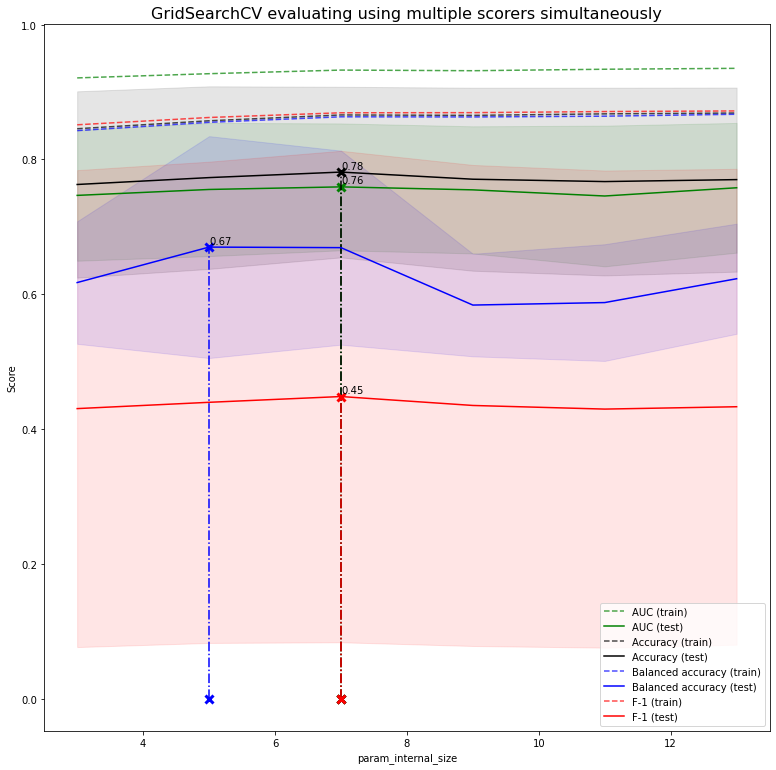

In [22]:
results = clf.cv_results_

from matplotlib import pyplot as plt
#scoring = {"score": "accuracy"}

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("param_internal_size")
plt.ylabel("Score")

ax = plt.gca()
#ax.set_xlim(0, 402)
#ax.set_ylim(0.8, 0.9)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_internal_size"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k", "b", "r"]):
#for scorer, color in zip(["score"], ["g"]):
    for sample, style in (("train", "--"), ("test", "-")):
        #scorer = "score"
        #color = "g"
        #sample = "test"
        #style = "-"
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )
    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [23]:
import pickle

# Open a file and use dump()
with open('./cv_results/Brady_ai.19x19.3-13.100k.balanced.pickle', 'wb') as file:
    # A new file will be created
    pickle.dump(results, file)
results#['mean_test_score']

{'mean_fit_time': array([ 952.18728533, 1225.67647552, 1527.7200398 , 1758.25320663,
        1942.13271503, 2138.91362262]),
 'std_fit_time': array([120.1081767 , 185.60162764, 215.40100433, 263.94678488,
        289.13128087, 299.26724015]),
 'mean_score_time': array([15.41809621, 17.29925299, 21.35319247, 25.00650191, 26.72415953,
        28.87991452]),
 'std_score_time': array([6.41699147, 6.11635879, 7.74060441, 7.61477609, 9.23405839,
        9.95603735]),
 'param_internal_size': masked_array(data=[3, 5, 7, 9, 11, 13],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'internal_size': 3},
  {'internal_size': 5},
  {'internal_size': 7},
  {'internal_size': 9},
  {'internal_size': 11},
  {'internal_size': 13}],
 'split0_test_AUC': array([0.69731927, 0.72242673, 0.70766174, 0.71739585, 0.66230019,
        0.7260551 ]),
 'split1_test_AUC': array([0.66284913, 0.67573161, 0.6860577 , 0.67756139, 0.65705545,
  

In [25]:
results#['mean_test_score']

{'mean_fit_time': array([ 952.18728533, 1225.67647552, 1527.7200398 , 1758.25320663,
        1942.13271503, 2138.91362262]),
 'std_fit_time': array([120.1081767 , 185.60162764, 215.40100433, 263.94678488,
        289.13128087, 299.26724015]),
 'mean_score_time': array([15.41809621, 17.29925299, 21.35319247, 25.00650191, 26.72415953,
        28.87991452]),
 'std_score_time': array([6.41699147, 6.11635879, 7.74060441, 7.61477609, 9.23405839,
        9.95603735]),
 'param_internal_size': masked_array(data=[3, 5, 7, 9, 11, 13],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'internal_size': 3},
  {'internal_size': 5},
  {'internal_size': 7},
  {'internal_size': 9},
  {'internal_size': 11},
  {'internal_size': 13}],
 'split0_test_AUC': array([0.69731927, 0.72242673, 0.70766174, 0.71739585, 0.66230019,
        0.7260551 ]),
 'split1_test_AUC': array([0.66284913, 0.67573161, 0.6860577 , 0.67756139, 0.65705545,
  

## Show SpCV geographic locations

In [ ]:
from matplotlib import pyplot as plt
f, axarr = plt.subplots(1,2)
rSpCV.folding.plot('Fold', ax=axarr[0], markersize=3)
rSpCV.folding.plot('z', ax=axarr[1], markersize=3)
plt.show()

# Pull next cross-validation training and test sets
tr, ts = next(cv)
rSpCV.folding.iloc[tr].plot('z') # Plot training set using geographical coordinates

### [Optional] Testing multidimensional image rotation

In [ ]:
from skimage.transform import rotate
my_img = X[2]
print(my_img.shape)
pyplot.imshow(my_img[:,:, 1])
pyplot.show()
f, axarr = pyplot.subplots(1,2)
axarr[0].imshow(rotate(my_img, angle=15*np.random.randint(6), center=(2,2), mode='symmetric')[:,:, 1])
axarr[1].imshow(rotate(my_img, angle=15*np.random.randint(6), center=(2,2), mode='symmetric')[:,:, 1])
pyplot.show()
my_img.shape
f, axarr = pyplot.subplots(1,2)
axarr[0].imshow(rotate(my_img, angle=15*np.random.randint(6), mode='symmetric')[:,:, 1])
axarr[1].imshow(rotate(my_img, angle=15*np.random.randint(6), mode='symmetric')[:,:, 1])
pyplot.show()
my_img.shape

In [ ]:
import gc
gc.collect()

In [ ]:
import keras.backend as K
K.clear_session()

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
!python --version
!conda env list

In [ ]:
results#['mean_test_score']

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

In [ ]:
len(gpus)